In [1]:
import numpy as np
import matplotlib.pyplot as plt

import subprocess
import os
import json
import csv
import getpass

In [2]:
rates = range(1000, 100, -50)
print(rates)
timeout = 60
base_config = "../../../../test/e2e/networks/simple.toml"
modified_config = "../../../../test/e2e/networks/simple_modified.toml"
aggregate_file = "aggregated_out.csv"

sudo_password = getpass.getpass("Enter sudo password: ")
subprocess.run(["sudo", "-S", "echo", "test"], input=sudo_password.encode())

# Clear old aggregate file
if os.path.exists(aggregate_file):
    os.remove(aggregate_file)

# Run experiments
for i, rate in enumerate(rates):
    print(f"Running test with load_rate = {rate}ms")

    # Modify the config file
    with open(base_config, "r") as src, open(modified_config, "w") as dst:
        for line in src:
            if line.startswith("load_rate"):
                dst.write(f"load_rate = \"{rate}ms\"\n")
            else:
                dst.write(line)

    # Run the test
    test_cmd =f"../../../../test/e2e/build/runner -p -f {modified_config} benchmark"
    stop_cmd = f"../../../../test/e2e/build/runner -p -f {modified_config} stop"

    while True:
        try:
            subprocess.run(test_cmd, shell=True, timeout=timeout)
            break
        except:
            print(f"Timing out after {timeout}s")
    
    subprocess.run(stop_cmd, shell=True, timeout=60)

    report_cmd = [
        "sudo", "-S",
        "../../../../test/loadtime/build/report",
        "--nstates", "4",
        "--database-type", "goleveldb",
        "--data-dir", "../../../../test/e2e/networks/simple_modified/validator00/data",
        "--csv", f"out_{rate}.csv"
    ]
    subprocess.run(report_cmd, timeout=60, input=sudo_password.encode())

    print("-------- Aggregating results...")
    with open(f"out_{rate}.csv", "r") as infile, open(aggregate_file, "a") as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        for j, row in enumerate(reader):
            if i == 0 and j == 0:
                writer.writerow(row)  # header
            elif j > 0:
                row[0] = f"{rate}"  # update experiment_id
                row[5] = 1000 // rate
                writer.writerow(row)


range(1000, 100, -50)


[sudo] password for hoang: 

test
Running test with load_rate = 1000ms
Testnet load rate: 1s
I[2025-05-23|09:54:56.625] Removing Docker containers and networks      
I[2025-05-23|09:54:57.380] cleanup dir                                  msg="Removing testnet directory `../../../../test/e2e/networks/simple_modified`"
I[2025-05-23|09:54:57.636] setup                                        msg="Generating testnet files in `../../../../test/e2e/networks/simple_modified`"
I[2025-05-23|09:54:57.654] Starting initial network nodes...            
I[2025-05-23|09:54:57.654] load                                         msg="Starting transaction load (16 workers)..."
E[2025-05-23|09:54:57.655] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5701/v1\": dial tcp 127.0.0.1:5701: connect: connection refused"
E[2025-05-23|09:54:57.655] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5710/v1\": dial tcp 127.0.0.1:5710: connect: connection refused"

INFO	Reading aggregated_out.csv...
INFO	Found experiment 1000 with rate=1, connections=1
INFO	Found experiment 950 with rate=1, connections=1
INFO	Found experiment 900 with rate=1, connections=1
INFO	Found experiment 850 with rate=1, connections=1
INFO	Found experiment 800 with rate=1, connections=1
INFO	Found experiment 750 with rate=1, connections=1
INFO	Found experiment 700 with rate=1, connections=1
INFO	Found experiment 650 with rate=1, connections=1
INFO	Found experiment 600 with rate=1, connections=1
INFO	Found experiment 550 with rate=1, connections=1
INFO	Found experiment 500 with rate=2, connections=1
INFO	Found experiment 450 with rate=2, connections=1
INFO	Found experiment 400 with rate=2, connections=1
INFO	Found experiment 350 with rate=2, connections=1
INFO	Found experiment 300 with rate=3, connections=1
INFO	Found experiment 250 with rate=4, connections=1
INFO	Found experiment 200 with rate=5, connections=1
INFO	Found experiment 150 with rate=6, connections=1
INFO	For 1

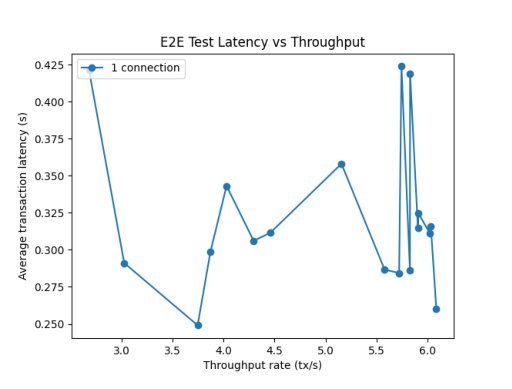

In [3]:
plot_cmd = [
    "python", "../latency_throughput.py",
    "-t", "E2E Test Latency vs Throughput",
    "e2e_latency_plot.png",
    "aggregated_out.csv"
]
subprocess.run(plot_cmd)

# show image of the plot
plt.imshow(plt.imread("e2e_latency_plot.png"))
plt.axis('off')
plt.show()